In [27]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import DataProcessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input, Dropout,Attention, Activation, Flatten, TimeDistributed, RepeatVector, Permute, Multiply, Lambda,Bidirectional
from keras import backend as K
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras_self_attention import SeqSelfAttention
import tensorflow as tf

dataProcess = DataProcessing.ETL()
path1='./historical_data/Binance_ETHUSDT_d.csv'
path2= './historical_data/Binance_BTCUSDT_d.csv'
df = dataProcess.Load_Clean_Data(path1,'1d')

cols= ['ti_stoch_kd','ti_MACD']
cols_to_normalize = ['open','high', 'low', 'close', 'base_volume'] # removed num_trades
# cols_to_normalize = ['close', 'base_volume'] # removed num_trades

df = dataProcess.Add_TI_Data(df, cols=cols)
df= dataProcess.Add_Label(df,cols_to_normalize=cols_to_normalize)
#important: reverse the order and Reset the index to start from 0
df= df[::-1]
df.reset_index(drop=True, inplace=True)


#removed time ('unix_start_datetime')
x_cols = cols_to_normalize+cols
labels = ['result_A','result_B']
tensor_temp= df[x_cols+labels]
sequence_num= 14 # also called timesteps
tensor = dataProcess.create_tensor_with_sequence(tensor_temp,labels,sequence_num)
#note we have 2 labels, one for daily(B) another for shortterm (A) => shorterm>daily
#y1= df['result_A']
X= tensor.loc[:,~tensor.columns.isin(labels)]


y2= tensor['result_B']

y = y2.replace({'up': 0, 'down': 1, 'flat':2})
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=3)



# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
# further split training data into training and validation sets
# # Create the oversampling object
# # Oversample the data

# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

# Important: reshape it into a 3D tensor with dimensions (number of samples, sequence length, number of features) to process with LSTM
X_train = X_train.to_numpy().reshape(X_train.shape[0],sequence_num+1,len(x_cols))
X_test = X_test.to_numpy().reshape(X_test.shape[0],sequence_num+1,len(x_cols))
X_val = X_val.to_numpy().reshape(X_val.shape[0],sequence_num+1,len(x_cols))

model = Sequential([
Bidirectional(LSTM(units=90, return_sequences=True, input_shape=(sequence_num+1,len(x_cols)))),
Dropout(0.4),
Bidirectional(LSTM(units=64,
                    return_sequences=True
                    )),
Dropout(0.6),
Bidirectional(
    LSTM(
    units=32,
    return_sequences=True
    )),
Dropout(0.6),
SeqSelfAttention(attention_activation='tanh'),
Flatten(),
Dense(3,activation='softmax')])


model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       ])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 28)

created
Epoch 1/28


/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


31/31 [==============================] - 6s 52ms/step - loss: 0.9787 - accuracy: 0.5036 - precision_16: 0.4778 - recall_16: 0.1753 - tp: 172.0000 - fp: 188.0000 - tn: 1774.0000 - fn: 809.0000 - val_loss: 0.9148 - val_accuracy: 0.5226 - val_precision_16: 0.5664 - val_recall_16: 0.1520 - val_tp: 64.0000 - val_fp: 49.0000 - val_tn: 793.0000 - val_fn: 357.0000
Epoch 2/28
31/31 [==============================] - 1s 24ms/step - loss: 0.9103 - accuracy: 0.5260 - precision_16: 0.5683 - recall_16: 0.3435 - tp: 337.0000 - fp: 256.0000 - tn: 1706.0000 - fn: 644.0000 - val_loss: 0.9012 - val_accuracy: 0.5392 - val_precision_16: 0.5776 - val_recall_16: 0.3800 - val_tp: 160.0000 - val_fp: 117.0000 - val_tn: 725.0000 - val_fn: 261.0000
Epoch 3/28
31/31 [==============================] - 1s 24ms/step - loss: 0.9120 - accuracy: 0.5250 - precision_16: 0.5351 - recall_16: 0.3109 - tp: 305.0000 - fp: 265.0000 - tn: 1697.0000 - fn: 676.0000 - val_loss: 0.9192 - val_accuracy: 0.5487 - val_precision_16: 0.57

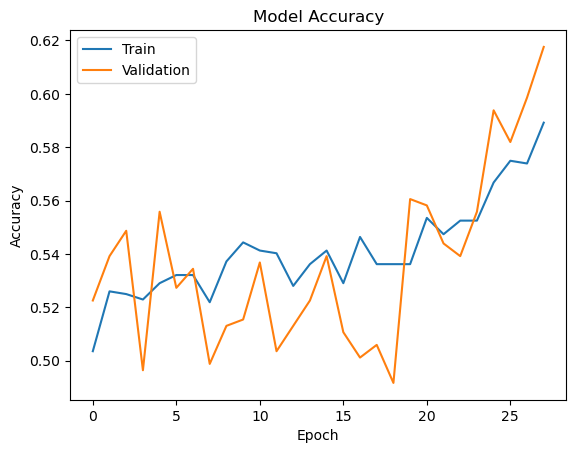

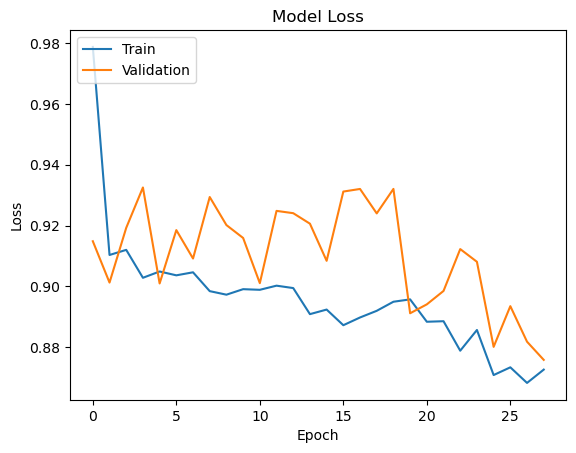

19/19 [==============================] - 0s 6ms/step - loss: 0.9399 - accuracy: 0.5797 - precision_16: 0.5932 - recall_16: 0.5233 - tp: 315.0000 - fp: 216.0000 - tn: 988.0000 - fn: 287.0000
Accuracy: 0.579734206199646
Precision: 0.5932203531265259
Recall: 0.5232558250427246
F1 Score: 0.5560459083262254
True Positive: 315.0
True Negative: 988.0
False Positive: 216.0
False Negative: 287.0


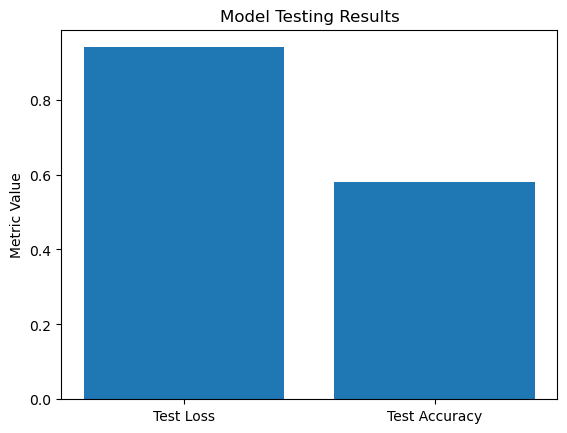

14/14 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.49      0.79      0.60       170
           1       0.67      0.46      0.55       216
           2       0.00      0.00      0.00        35

   micro avg       0.55      0.55      0.55       421
   macro avg       0.39      0.42      0.38       421
weighted avg       0.54      0.55      0.52       421
 samples avg       0.55      0.55      0.55       421



/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#data visualization and summerization
dataProcess.visualizeValidation(history)

loss, accuracy, precision, recall, tp, fp, tn, fn = model.evaluate(X_test, y_test)

# # Calculate precision, recall, and F1 score
# precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average= None)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", (2*(recall*precision)/(recall + precision)))
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Plot testing accuracy and loss
plt.bar(['Test Loss', 'Test Accuracy'], [loss, accuracy])
plt.title('Model Testing Results')
plt.ylabel('Metric Value')
plt.show()
#for table
y_pred = model.predict(X_val)

result = dataProcess.getPredictionData(y_pred)
print(classification_report(y_val, result))